In [8]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from IPython.display import HTML
from sklearn.decomposition import PCA
import umap

ROOT = Path.cwd().resolve().parent if Path.cwd().name == "notebooks" else Path.cwd()
# Force project root = folder that contains "results"
RESULTS_PATH = ROOT / "results" / "embeddings.json"
print("Resolved root:", ROOT)
print("Looking for:", RESULTS_PATH)
assert RESULTS_PATH.exists(), f"embeddings.json not found in {RESULTS_PATH}"
ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "results").exists():
    ROOT = ROOT.parent
print("Project rootL:", ROOT)
print("Embeddings file:", RESULTS_PATH)

assert RESULTS_PATH.exists(), "Run the Day 5 embedding exponent export first."

with open(RESULTS_PATH, "r") as f:
    emb_data = json.load(f)

#emb_data: {family_name: [[d0,d1,...], ...]...}
families = list(emb_data.keys())
print(f"Loaded families: {len(families)}")



Resolved root: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
Looking for: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/results/embeddings.json
Project rootL: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/notebooks
Embeddings file: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/results/embeddings.json
Loaded families: 21


In [9]:
from pathlib import Path
import json

ROOT = Path.cwd().resolve().parent if Path.cwd().name == "notebooks" else Path.cwd()
emb_path = ROOT / "results" / "embeddings.json"
print("Embeddings path:", emb_path, "| exists:", emb_path.exists())

with open(emb_path, "r") as f:
    emb_data = json.load(f)

print("Number of families in embeddings.json:", len(emb_data))
for fam, vecs in emb_data.items():
    print(f"  {fam}: {len(vecs)} sequences")

Embeddings path: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/results/embeddings.json | exists: True
Number of families in embeddings.json: 21
  Antenna: 47 sequences
  C2Domain: 100 sequences
  Fibronectin: 28 sequences
  Granulin: 17 sequences
  Guanine: 28 sequences
  Kringle: 96 sequences
  Melatonin: 25 sequences
  Metallothionein: 100 sequences
  OuterMembraneUsher: 39 sequences
  PPE: 97 sequences
  Phosphatase: 40 sequences
  Phosphocarrier: 81 sequences
  Phosphofructokinase: 100 sequences
  PotexCarlavirusCoat: 30 sequences
  Prepilin: 36 sequences
  PrepilinEndopeptidase: 36 sequences
  Retinoid: 33 sequences
  Retroviral: 80 sequences
  SsrABinding: 100 sequences
  UbiquitinE1: 31 sequences
  ZincFingerAN1: 64 sequences


In [10]:
#flatten embeddings into a Dataframe/matrix
#turning the embeddings into a table
# each row is a protein sequence 
#each column is a number from the embedding
import pandas as pd
import numpy as np
'''
    "familyA": [ [0.2, 0.1, 0.9, ...], [0.4, 0.3, 0.8, ...], ... ],
    "familyB": [ ... ],
'''
rows = []
for fam, vecs in emb_data.items():
    for v in vecs:
        arr = np.asarray(v, dtype=float)
        if arr.ndim > 1:
            arr = arr.reshape(-1)   # flatten any (1, D) / (D,1) etc
        row = {"family": fam}
        for i, val in enumerate(arr):
            row[f"d{i}"] = float(val)
        rows.append(row)
        # rows.append(
        #     {"family": fam, **{f"d{i}": v[i] for i in range(len(v))}}
        # )
df = pd.DataFrame(rows) #like a table
feat_cols = []
for c in df.columns:
    if c.startswith("d"):
        feat_cols.append(c)
# feat_cols = [c for c in df.columns if c.startswith("d")]

print("df shape:", df.shape)
print("number of embedding features:", len(feat_cols))
print("families (first 5):", df["family"].unique()[:5])
# df.head()


df shape: (1208, 129)
number of embedding features: 128
families (first 5): ['Antenna' 'C2Domain' 'Fibronectin' 'Granulin' 'Guanine']


In [11]:
#PCA/UMAP projection from 128D to 2D

X = df[feat_cols].to_numpy() #getting embedding columns

#PCA
#1.Learns the directions of maximum variance in your data
#2.	Turns each 128-dim embedding into 2D:

# - build numeric feature matrix
pca = PCA(n_components=2, random_state=42) #create PCA model
Z_pca = pca.fit_transform(X)
df["x_pca"] = Z_pca[:, 0]
df["y_pca"] = Z_pca[:, 1]

X = df[feat_cols].to_numpy(dtype=float)
n_samples, n_features = X.shape
print("PCA explained variance:", pca.explained_variance_ratio_[:2])
if n_samples < 2 or n_features < 2:
    print("⚠️ Not enough data for 2D PCA. Using dummy coordinates.")
    df["x_pca"] = np.zeros(n_samples)
    df["y_pca"] = np.arange(n_samples)
    HAS_PCA = False
try:
#try to create UMAP model
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        metric="cosine",
        random_state=42,
    )
    Z_umap = reducer.fit_transform(X)
    '''
        Produces a 2D layout similar to PCA, but usually:
        •	tighter clusters
        •	curved / non-linear shapes
        •	more biologically meaningful visual separation
    '''
    df["x_umap"] = Z_umap[:, 0]
    df["y_umap"] = Z_umap[:, 1]
    HAS_UMAP = True
    print("UMAP projection computed.")
except Exception as e:
    HAS_UMAP = False
    print("UMAP failed, using PCA only:", e)
#prevents crashing if dependencies not installed or anything missing


PCA explained variance: [0.52169154 0.36370692]


/Users/mderaznasr/Documents/GitHub/Protein-fewshot/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP projection computed.


In [ ]:
#plotly scatter (PCA projection)
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import plotly.io as pio
from IPython.display import HTML
import numpy as np

pio.renderers.default = "browser"

use_umap = HAS_UMAP if "HAS_UMAP" in globals() else False
use_pca = True     # PCA is always available

if use_umap:
    xcol, ycol = "x_umap", "y_umap"
    title = "Protein Embeddings (UMAP projection, 2D)"
else:
    xcol, ycol = "x_pca", "y_pca"
    title = "Protein Embeddings (PCA projection, 2D)"

print(f"Using {title} projection for plotting → ({xcol}, {ycol})")

# embedding L2 norm (just for fun / hover)
vecs = df[feat_cols].to_numpy()
df["norm"] = np.linalg.norm(vecs, axis=1)

family_list = sorted(df["family"].unique())
family_search = widgets.Text(
    value="",
    placeholder="Type to filter families...",
    description="Search:"
)
family_selector = widgets.SelectMultiple(
    options=family_list,
    value=tuple(family_list),
    description="Families",
    rows = 8
)

def filter_df():
    ''' Return filtered dataframe based on widget selections.'''
    if family_search.value.strip():
        filtered = [f for f in family_list if family_search.value.lower() in f.lower()]
        family_selector.options = filtered
        selected = filtered
    else:
        selected = list(family_selector.value)
        family_selector.options = family_list
    
    return df[df["family"].isin(selected)].copy()

def make_plot(_):
    dff = filter_df()  

    fig = px.scatter(
        dff,
        x=xcol,
        y=ycol,
        color="family",
        hover_data=["family", "norm"],
        title=f"{title} (Filtered: {len(dff)} proteins)",
        width=900,
        height=650,
        opacity=0.82,
    )

    fig.update_traces(marker=dict(size=6, line=dict(width=0)))
    fig.update_layout(legend_title_text="Protein Family")
    fig.show()

    html_path = ROOT / "results" / "plot_interactive.html"
    pio.write_html(fig, html_path, auto_open=False)
    print(f"Saved interactive HTML -> {html_path}")

#Download filtered subset as CSV
def download_filtered(_):
    dff = filter_df()
    csv_path = ROOT / "results" / "filtered_embeddings.csv"
    dff.to_csv(csv_path, index=False)
    print(f"Saved filtered CSV -> {csv_path}")

download_button = widgets.Button(description="Download Filtered CSV")
download_button.on_click(download_filtered)
plot_button = widgets.Button(description="Update Plot")
plot_button.on_click(make_plot)

#Display UI
print("\n Controls Loaded")
display(family_search, family_selector, plot_button, download_button)
make_plot(None)

Using Protein Embeddings (UMAP projection, 2D) projection for plotting → (x_umap, y_umap)

 Controls Loaded


Text(value='', description='Search:', placeholder='Type to filter families...')

SelectMultiple(description='Families', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

Button(description='Update Plot', style=ButtonStyle())

Button(description='Download Filtered CSV', style=ButtonStyle())

Saved interactive HTML -> /Users/mderaznasr/Documents/GitHub/Protein-fewshot/results/plot_interactive.html


In [ ]:
#Simple nearest-neighbour inspection (cosine)
from sklearn.metrics.pairwise import cosine_similarity
# build [num_seq, D] matrix
X_vecs = df[feat_cols].to_numpy()
def nearest_neighbours(idx: int, k: int = 10):
    """
    Given a row index in df, print the top-k most similar points by cosine.
    """
    query = X_vecs[idx:idx+1]             # (1, D)
    scores = cosine_similarity(query, X_vecs)[0]
    top_idx = np.argsort(-scores)[:k]
    
    print(
        f"Query idx={idx}  name={df.loc[idx,'name']}  "
        f"family={df.loc[idx,'family']}"
    )
    print("Top neighbours:")
    for j in top_idx:
        print(
            f"  idx={j:4d}  sim={scores[j]:.3f}  "
            f"family={df.loc[j,'family']}  name={df.loc[j,'name']}"
        )
# Example: inspect a random point
nearest_neighbours(idx=0, k=10)

Query idx=0  name=Antenna_0  family=Antenna
Top neighbours:
  idx=   0  sim=1.000  family=Antenna  name=Antenna_0
  idx=  37  sim=1.000  family=Antenna  name=Antenna_37
  idx=  33  sim=1.000  family=Antenna  name=Antenna_33
  idx=  13  sim=1.000  family=Antenna  name=Antenna_13
  idx=  28  sim=1.000  family=Antenna  name=Antenna_28
  idx=  10  sim=1.000  family=Antenna  name=Antenna_10
  idx=  44  sim=1.000  family=Antenna  name=Antenna_44
  idx=   7  sim=1.000  family=Antenna  name=Antenna_7
  idx=  34  sim=1.000  family=Antenna  name=Antenna_34
  idx=   1  sim=1.000  family=Antenna  name=Antenna_1


In [14]:
# Fix: add per-sequence index and a simple "name" column
# Ensure index is clean
df = df.reset_index(drop=True)
# seq_idx = index of the sequence within its family
df["seq_idx"] = df.groupby("family").cumcount()
# Simple name: "Family_seqIndex"
df["name"] = df["family"].astype(str) + "_" + df["seq_idx"].astype(str)
print(df[["family", "seq_idx", "name"]].head())

    family  seq_idx       name
0  Antenna        0  Antenna_0
1  Antenna        1  Antenna_1
2  Antenna        2  Antenna_2
3  Antenna        3  Antenna_3
4  Antenna        4  Antenna_4


In [16]:
#Plotly scatter (UMAP projection, if available)
if HAS_UMAP:
    fig = px.scatter(
        df,
        x="x_umap",
        y="y_umap",
        color="family",
        hover_data=["name", "family", "seq_idx"],
        title="Protein Embeddings (UMAP, color = family)",
    )
    fig.show()
else:
    print("UMAP not available; skip this cell or install/enable it.")

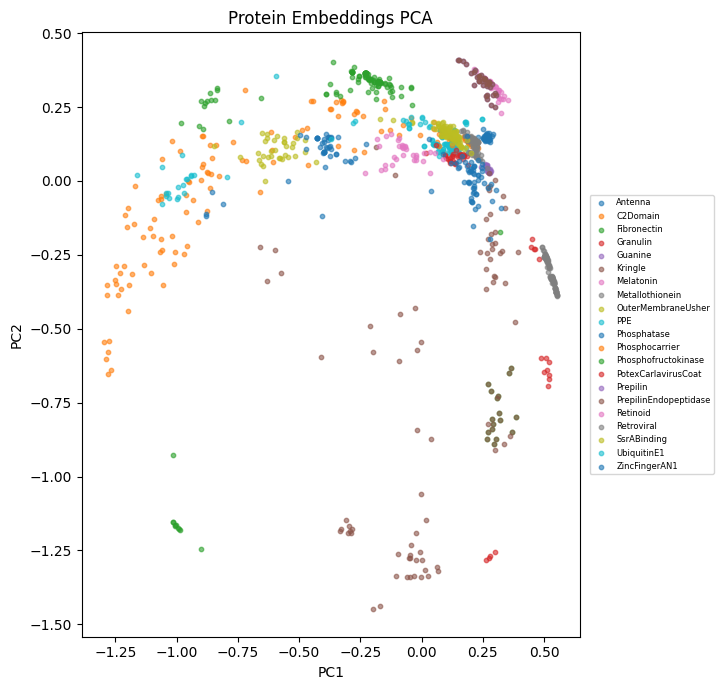

Saved: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/results/pca_embeddings.png


In [20]:
#Save a static figure for your report (Matplotlib)

plt.figure(figsize=(9,7))
for fam, sub in df.groupby("family"):
    plt.scatter(sub["x_pca"], sub["y_pca"], s=10, alpha=0.6, label=fam)

plt.legend(
    fontsize=6, 
    loc="center left", # vertical center, left edge
    bbox_to_anchor=(1.02, 0.5), # shift legend fully outside
    borderaxespad=0,
)
plt.title("Protein Embeddings PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout(rect=[0, 0, 0.82, 1]) 

out_fig = ROOT / "results" / "pca_embeddings.png"
out_fig.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_fig, dpi=160)
plt.show()
print("Saved:", out_fig)

## Results & Visualization

We evaluate the ProtNet-style encoder on N-way K-shot episodes sampled from
held-out protein families.

- **Episode accuracy (5-way, 5-shot, Q=10):**  
  ~0.91 ± 0.08 (cosine) and ~0.91 ± 0.09 (euclidean) over 150 episodes.  
  Random chance for 5-way classification is 0.20.

- **Confusion matrix:**  
  The episode-averaged confusion matrix is close to diagonal, showing that
  the model consistently separates the 5 classes within each episode.

- **Embedding space:**  
  We project the learned embeddings to 2D using PCA/UMAP and visualise them
  with an interactive Plotly + Streamlit dashboard. Points are coloured by
  protein family; related families form tight, well-separated clusters.

The Streamlit app (`app.py`) exposes:

- A global 2D embedding map (PCA/UMAP).
- Hover tooltips with family + index metadata.
- A nearest-neighbour search to inspect which proteins are considered similar.
- Download buttons for `embeddings.json` and `embeddings.csv`.

Together, this gives both **quantitative** (episode-level) and
**qualitative** (embedding geometry) evidence that the encoder has learned
biologically meaningful structure.